In [120]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [1]:
with open("sequences.fasta", "r") as iofile:
    file = iofile.readlines()

In [2]:
file

['>Caenorhabditis|NP_505463.1|H2A|cH2A organism=Caenorhabditis elegans phylum=Nematoda class=Chromadorea\n',
 '------------------------------------------------------------\n',
 '------------------------------------------------------------\n',
 '------------------------------------------------------------\n',
 '-MSGR-------------------------------------------------------\n',
 '----------GKG-G-----------------------------------KAK-------\n',
 '----TGG-KA---KS------------------R-SSR----AGLQFPVG----------\n',
 '------------------------------------------------------------\n',
 '-RLHRIL--RKGNYAQ--RV-----------GA-------------GAPVYL--A----A\n',
 'VLEYLAA----------EV----LELA----GN----------AA--R----D-N----K\n',
 'KT----------RI-------APRHL-QLA--------VRNDEELN-KLLA-G---VT--\n',
 '-----------IAQG-----------GVLPNIQA----------VL--LPKKTAGDKE--\n',
 '------------------------------------------------------------\n',
 '------------------------------------------------------------\n',
 '------------------

In [40]:
identificators = [x.strip() for i,x in enumerate(file) if ">" in x]
gistons = set([x.split("|")[2] for x in identificators])
vocab = set()
for string in file:
    if ">" not in string:
        for symb in string.strip():
            vocab.add(symb)

vocab = vocab.union(gistons)
print(len(vocab))

28


In [93]:
token_to_idx = {x:i for i,x in enumerate(vocab)}
idx_to_token = {i:x for i,x in enumerate(vocab)}
cur_row = ""
file_connected = []

for row in file:
    row = row.strip()  
    if ">" not in row:  
        cur_row += row  
    else:
        if cur_row:  
            file_connected.append(cur_row) 
            cur_row = ""
if cur_row:
    file_connected.append(cur_row)

data = [[int(token_to_idx[t]) for t in list(x.strip())] for x in file_connected if ">" not in x]
targets = [int(token_to_idx[x.split("|")[2]]) for x in file if ">" in x]

In [103]:
data_tensor = torch.Tensor(data).long()
targets_tensor = torch.Tensor(targets).long()
data_tensor.shape, targets_tensor.shape

(torch.Size([565, 908]), torch.Size([565]))

In [110]:
embedding_dim = 28
hidden_dim = 9
vocab_size = 28
data_size = 565
n_layers = 1

class RNNWithAttentionModel(nn.Module):
   def __init__(self, random_seed=5):
       super(RNNWithAttentionModel, self).__init__()
       torch.manual_seed(random_seed)
       torch.cuda.manual_seed(random_seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False
       # Create an embedding layer for the vocabulary
       self.embedding = nn.Embedding(vocab_size, embedding_dim) # your code here
       # Create an RNN layer
       self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers) # your code here
       # Apply a linear transformation to get the attention scores
       self.attention = nn.Linear(hidden_dim, hidden_dim)# your code here
       self.fc = nn.Linear(hidden_dim, vocab_size)
   def forward(self, x):
       x = self.embedding(x)
       out, _ = self.rnn(x)
       attention_out = self.attention(out).squeeze(2)
       #  Get the attention weights
       attention_weights = torch.softmax(attention_out, dim=2) # your code here
       # Compute the context vector
       context = out * attention_weights  
       context = context.sum(dim=1) # your code here
       out = self.fc(context)
       return out


In [114]:
def train_model(model, opt, X_train, y_train, n_epoch=700, log_period=1):
    loss_fn = torch.nn.CrossEntropyLoss()  
    loss_train = []
    acc_train = []

    for epoch_num in range(n_epoch):
        model.train()
        opt.zero_grad() 

        y_predicted = model(X_train)

        loss = loss_fn(y_predicted, y_train)  
        loss.backward()  
        opt.step()  

        if epoch_num % log_period == 0:
            loss_train.append(loss.item())
            _, predicted_classes = torch.max(y_predicted, 1)  
            acc = (predicted_classes == y_train).float().mean() 
            acc_train.append(acc.item())

    return model, loss_train, acc_train

In [115]:
model = RNNWithAttentionModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
model, loss_train, acc_train = train_model(model, opt, data_tensor, targets_tensor)

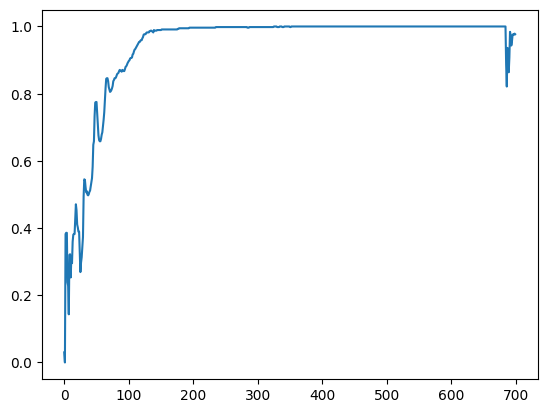

In [121]:
plt.plot(np.arange(700), acc_train)

In [146]:
acc_train[-1]

0.9769911766052246

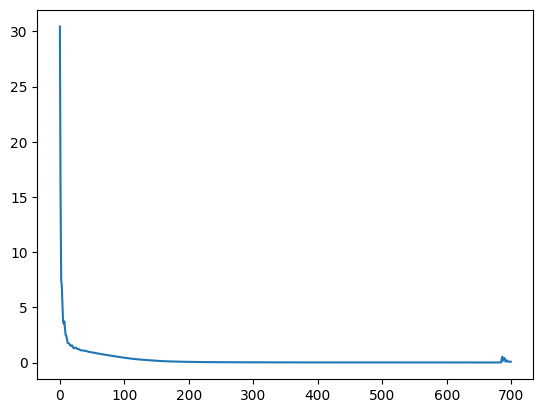

In [122]:
plt.plot(np.arange(700), loss_train)

In [124]:
loss_train[100:110]

[0.43048572540283203,
 0.4223294258117676,
 0.4142267107963562,
 0.4062363803386688,
 0.3984527587890625,
 0.3908957242965698,
 0.38349640369415283,
 0.37619921565055847,
 0.36899054050445557,
 0.36186683177948]

In [125]:
seq_fasta = '''>Pan|XP_003311177.1|HTYPE|HVARIANT 

MSGRGKQGGKARTKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT 

AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK 

TESHHKAKGK'''

In [141]:
data_seq = [int(token_to_idx[x.strip()]) for x in seq_fasta.split("HVARIANT")[1] if len(x.strip())>0]
data_seq_tensor = torch.Tensor(data_seq).view(1,-1).long()
data_seq_tensor.shape

torch.Size([1, 130])

In [145]:
clas = torch.argmax(model(data_seq_tensor)).item()
print(idx_to_token[clas])

H2A
